In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw1.ipynb")

<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Homework 1: Web Scraping, Data Parsing, and EDA

**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai



<hr style='height:2px'>

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Exercise **responsible scraping**. Web servers can become slow or unresponsive if they receive too many requests from the same source in a short amount of time. Use a delay of 2 seconds between requests in your code.  
- Web scraping requests can take several minutes. This is another reason why you should not wait until the last minute to do this homework.
- Plots should be legible and interpretable without having to refer to the code that generated them.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (this can take a few minutes)

In [2]:
import json
from time import sleep
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

<hr style='height:2px'>

## ⭐ Follow the stars in IMDb's list of "The Top 100 Stars for 2021" 

### Overview
In this assignment you'll practice scraping, parsing, and analyzing HTML data pulled from web.

Specifically, you'll extract information about each person on IMDb's list of "Top 100 Stars for 2021" (https://www.imdb.com/list/ls577894422/), perform some EDA, ask some questions of the data, and interpret your findings.

For example, we might like to know: 
- What is the relationship between when a performer started their career and their total number of acting credits? 
- How many stars started as child actors?
- How do the distribution of ages compare across genders?
- Who is the most prolific actress or actor in IMDb's list of the Top 100 Stars for 2021? 

These questions and more are addressed in details below. 

## Part 1 - Scraping and Parsing

<div class='exercise'><b>Q1 - Scrape Top Stars List</b></div>

Scrape the HTML from the webpage of the "Top 100 Stars for 2021" (https://www.imdb.com/list/ls577894422/) into a `requests` object and name it `my_page`. 

_Points:_ 2.5

In [3]:
top_stars_url = 'https://www.imdb.com/list/ls577894422/' # SOLUTION NO PROMPT
my_page = requests.get(top_stars_url) # SOLUTION
my_page.status_code  # SOLUTION NO PROMPT

200

In [ ]:
grader.check("q1")

<div class='exercise'><b>Q2 - Making BeautifulSoup</b></div>

Create a Beautiful Soup object named `star_soup` from the HTML content in `my_page`.


_Points:_ 2.5

In [5]:
star_soup = BeautifulSoup(my_page.content, "html.parser") # SOLUTION

In [6]:
# check your code - you should see a familiar HTML code
print (star_soup.prettify()[:1000])

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   var IMDbTimer={starttime: new Date().getTime(),pt:'java'};
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <title>
   Top 100 Stars of 2021 - IMDb
  </title>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
  </script>
  <link href="https://www.imdb.com/list/ls577894422/" rel="canonical"/>
  <meta content="http://www.imdb.com/list/ls577894422/" property="og

In [ ]:
grader.check("q2")

<div class='exercise'><b>Q3 - Parse Stars</b></div>

Write a function called `parse_stars` that accepts `star_soup` as its input and returns a list of dictionaries to be saved in a variable called `star_list` (see function definition below for details)

IMDb star pages do not have a 'sex' or 'gender' field. Some roles are gender neutral (e.g., "writer") and relying on actor/actress distinctions will also give results inconsistent with the more detailed data available on the site. You should infer gender based on the frequency of the personal pronouns used in each star's truncated bio that appears on the main "Top 100 Star of 2021" page.

You may find a data structure like this useful:

```python
pronouns = {'woman': ['she','her'],
            'man': ['he', 'him', 'his'],
            'non-binary': ['they', 'them', 'their']}
```

Simply count the occurrences of the different pronouns in the bio and make the classification based on the grouping with the majority count.

>**Hint:** Throughout this assignment you will likely find it useful to create small 'helper' functions which are then used by your larger functions like `parse_stars`

```
Function
--------
parse_stars

Input
------
star_soup: the soup object with the scraped page
   
Returns
-------
a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    name: (str) the name of the star
    role: (str) role in film designated on top 100 page (e.g., 'actress', 'writer')
    gender: (str) 'man', 'woman', or 'non-binary' based in pronoun counts in top 100 page bio
    url: (str) the url of the link under star's name that leads to a page with more details
    page: (bs4.BeautifulSoup) BS object acquired by scraping and parsing the above 'url' page

Example:
--------
{'name': 'Elizabeth Olsen',
 'role': 'actress',
 'gender': 'woman',
 'url': 'https://www.imdb.com/name/nm0647634',
 'page': <!DOCTYPE html>
 <html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
 <meta charset="utf-8"/>
 <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
 <script>
 ...
}

```

_Points:_ 25

In [8]:
# BEGIN SOLUTION NO PROMPT
BASE_URL = 'https://www.imdb.com'
PRONOUNS = {'woman': ['she','her'],
            'man': ['he', 'him', 'his'],
            'non-binary': ['they', 'them', 'their']}

def get_name(tag):
    return tag.select_one('a').text.strip()

def get_role(tag):
    return tag.select_one('p').text.split('|')[0].lower().strip()

def get_url(tag):
    return BASE_URL + tag.select_one('a').get('href')

def get_page(url):
    sleep(2)
    return BeautifulSoup(requests.get(url, 'html.parser').content)

def get_full_bio(tag):
    bio_page = get_page(BASE_URL+tag.select_one('.see-more a').get('href'))
    return bio_page.select_one('p').text.strip()

def count_pronouns(bio):
    pronoun_counts = [len(re.findall(rf"\W({'|'.join(pns)})\W", bio)) for pns in PRONOUNS.values()]
    return pronoun_counts
    
def get_gender(tag, page=None):
    # Try short bio first
    short_bio = tag.select('p')[1].text.strip().lower()
    pronoun_counts = count_pronouns(short_bio)
    # If no pronouns or tied among genders
    if len(set(pronoun_counts)) == 1:
        # Get star page if not provided
        if page is None:
            page = get_page(get_url(tag))
        # Then check full bio
        full_bio = get_full_bio(page)
        pronoun_counts = count_pronouns(full_bio)
    return list(PRONOUNS.keys())[np.argmax(pronoun_counts)]

# END SOLUTION

def parse_stars(star_soup) -> list:
    # BEGIN SOLUTION
    stars = star_soup.select('.lister-item-content')
    starlist = []
    for s in stars:
        d = {}
        d['name'] = get_name(s)
        d['role'] = get_role(s)
        # page & url needed for get_gender to avoid redundant requests
        url = get_url(s)
        page = get_page(url)
        d['gender'] = get_gender(s, page)
        d['url'] = url
        d['page'] = page
        starlist.append(d)
    return starlist
    # END SOLUTION

star_list = parse_stars(star_soup) # SOLUTION

In [9]:
# check your code
# this list is large because of the html code into the `page` field
# to get a better picture, print only the first element
star_list[0]

{'name': 'Elizabeth Olsen',
 'role': 'actress',
 'gender': 'woman',
 'url': 'https://www.imdb.com/name/nm0647634',
 'page': <!DOCTYPE html>
 <html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
 <meta charset="utf-8"/>
 <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
 <script>
     if (typeof uet == 'function') {
       uet("bb", "LoadTitle", {wb: 1});
     }
 </script>
 <script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
 <title>Elizabeth Olsen - IMDb</title>
 <script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
 <script>
     if (typeof uet == 'function') {
       uet("be", "LoadTitle", {wb: 1});
     }
 </script>
 <script>
     if (typeof uex == 'function') {
       uex("ld", "LoadTitle", {wb: 1});
     }
 </script>
 <link href="https://www.imdb.com/name/nm0647634

In [ ]:
grader.check("q3")

<div class='exercise'><b>Q4 - Create Star Table</b></div>

Write a function called `create_star_table`, which takes `star_list` as an input and returns a *new* list of dictionaries, `star_table`, which includes more extensive information about each star extracted from their `page`. 

See function the definition below for more details.

>**Note:** The years of some credits are ranges (e.g., 2001-2002). You should use only the starting year.

>**Hint:** Carefuly note the ordering, case, and data type of the values in each dictionary.

```
Function
--------
create_star_table

Input
------
star_list (list of dictionaries)
   
Returns
-------

a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    name: (str) the name of the star
    role: (str) 'actor', 'actress', 'writer', etc. (note the case)
    gender: (str) 'woman', 'man', or 'non-binary' (based on pronouns in bio)  
    year_born : (int) year star was born (some pages do note have a full date so we'll just use year)
    first_credit: (str) title of their first credit in their capacity designated by 'role'
    year_first_credit: (int) the year they made their first movie or TV show
    num_credits: (int) number of movies or TV shows they have made over their career in their capacity designated by 'role'
    
--------
Example:

{'name': 'Elizabeth Olsen',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1989,
  'first_credit': 'How the West Was Fun',
  'year_first_credit': 1994,
  'num_credits': 27}
  
```

_Points:_ 25

In [18]:
# BEGIN SOLUTION NO PROMPT
def get_year_born(page):
    return int(page.select_one('#name-born-info time').text.split()[-1].strip())


def get_credit_info(star_dict):
    filmo_section = star_dict['page'].find('div', attrs={'data-category': star_dict['role']})\
                                     .find_next(class_ = 'filmo-category-section')
    # Set credit in the future if there is no year listed
    # For year ranges (e.g., 1994-2000) use the start year
    parse_year = lambda x: 2025 if len(x) == 0 else int(re.findall('\d{4}', x)[0])
    credit_years = [parse_year(y.text.strip()) for y in filmo_section.select('.year_column')]
    credit_titles = [t.text.strip() for t in filmo_section.select('.filmo-row b')]
    first_idx = np.argsort(credit_years)[0]
    
    assert len(credit_years) == len(credit_titles)
    num_credits = len(credit_years)
    first_credit = credit_titles[first_idx]
    year_first_credit = credit_years[first_idx]
    return num_credits, first_credit, year_first_credit


def get_star_data(s: dict):
    d = {}
    d['name'] = s['name']
    d['role'] = s['role']
    d['gender'] = s['gender']
    d['year_born'] = get_year_born(s['page'])
    # perhaps easiest to gather all credit info at once
    num_credits, first_credit, year_first_credit = get_credit_info(s)
    d['first_credit'] = first_credit
    d['year_first_credit'] = year_first_credit
    d['num_credits'] = num_credits
    return d

# END SOLUTION
def create_star_table(star_list: list) -> list:
    # BEGIN SOLUTION 
    star_table = []
    for s in star_list:
        d = get_star_data(s)
        star_table.append(d)
    return star_table
    # END SOLUTION

In [19]:
star_table = create_star_table(star_list) # SOLUTION
# BEGIN SOLUTION NO PROMPT
with open("data/starinfo_2021_solutions.json", "w") as f:
    json.dump(star_table, f)
# END SOLUTION

In [20]:
# check your code
star_table

[{'name': 'Elizabeth Olsen',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1989,
  'first_credit': 'How the West Was Fun',
  'year_first_credit': 1994,
  'num_credits': 26},
 {'name': 'Regé-Jean Page',
  'role': 'actor',
  'gender': 'man',
  'year_born': 1988,
  'first_credit': 'Gimme 6',
  'year_first_credit': 2001,
  'num_credits': 20},
 {'name': 'Florence Pugh',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1996,
  'first_credit': 'The Falling',
  'year_first_credit': 2014,
  'num_credits': 28},
 {'name': 'Ana de Armas',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1988,
  'first_credit': 'Una rosa de Francia',
  'year_first_credit': 2006,
  'num_credits': 32},
 {'name': 'Yvonne Strahovski',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1982,
  'first_credit': 'Double the Fist',
  'year_first_credit': 2004,
  'num_credits': 39},
 {'name': 'Anya Taylor-Joy',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1996,
  'first_credit': '

In [ ]:
grader.check("q4")

### 💡 Saving and Restoring Our List of Dictionaries

It's good practice to save your data structure to disk once you've done all of your scraping. This way you can often avoid repeating all the HTTP requests which can be slow (and taxing on servers!).

We had to wait until this stage to save our data structure as the `bs4.BeautifulSoup` object in our original `star_list` (the `page` values) can not be easily [serialized](https://docs.python-guide.org/scenarios/serialization/).

The code provided below will save the data structure to a [JSON](https://www.json.org/json-en.html) file named `starinfo.json` in the data subdirectory.

In [34]:
# your code here
with open("data/starinfo.json", "w") as f:
    json.dump(star_table, f)

To confirm this worked as intended, open the JSON file and load its contents into a variable for viewing.

In [35]:
with open("data/starinfo.json", "r") as f:
    star_table = json.load(f)
    
# output should be the same
star_table

[{'name': 'Elizabeth Olsen',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1989,
  'first_credit': 'How the West Was Fun',
  'year_first_credit': 1994,
  'num_credits': 26},
 {'name': 'Regé-Jean Page',
  'role': 'actor',
  'gender': 'man',
  'year_born': 1988,
  'first_credit': 'Gimme 6',
  'year_first_credit': 2001,
  'num_credits': 20},
 {'name': 'Florence Pugh',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1996,
  'first_credit': 'The Falling',
  'year_first_credit': 2014,
  'num_credits': 28},
 {'name': 'Ana de Armas',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1988,
  'first_credit': 'Una rosa de Francia',
  'year_first_credit': 2006,
  'num_credits': 32},
 {'name': 'Yvonne Strahovski',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1982,
  'first_credit': 'Double the Fist',
  'year_first_credit': 2004,
  'num_credits': 39},
 {'name': 'Anya Taylor-Joy',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1996,
  'first_credit': '

This method of saving and restoring data structures will likely be useful to you in the future!

## Part 2 - Pandas and EDA

<div class='exercise'><b>Q5 - Creating a DataFrame</b></div>

For the sake of consistency, we've provide our own JSON file, `data/starinfo_2021_staff.json`, which you should use for the rest of the notebook. Load the contents of this JSON file and use it to create a Pandas DataFrame called `frame`. 

>**Hint:** Remember, the data structure in the JSON file is a list of dictionaries.

_Points:_ 2.5

In [36]:
# BEGIN SOLUTION NO PROMPT
with open("data/starinfo_2021_staff.json", "r") as f:
    star_table = json.load(f)
# END SOLUTION
frame = pd.DataFrame(star_table) # SOLUTION

In [37]:
# Take a peek
frame.head(20)

,name,role,gender,year_born,first_credit,year_first_credit,num_credits
0,Elizabeth Olsen,actress,woman,1989,How the West Was Fun,1994,26
1,Regé-Jean Page,actor,man,1988,Gimme 6,2001,20
2,Florence Pugh,actress,woman,1996,The Falling,2014,28
3,Ana de Armas,actress,woman,1988,Una rosa de Francia,2006,32
4,Yvonne Strahovski,actress,woman,1982,Double the Fist,2004,39
5,Anya Taylor-Joy,actress,woman,1996,Vampire Academy,2014,32
6,Alexandra Daddario,actress,woman,1986,All My Children,2002,62
7,Jodie Comer,actress,woman,1993,The Royal Today,2008,34
8,Ben Barnes,actor,man,1981,The Kooks: The Sofa Song,2005,37
9,Lily James,actress,woman,1989,Just William,2010,35


In [ ]:
grader.check("q5")

<div class='exercise'><b>Q6 - Creating a New Column</b></div>

Add a new column to your dataframe with the *approximate* age of each star at the time of their first credit. Name this new column `age_at_first_credit`.

>**NOTE:** We say *approximate* age because we've only collected the year of birth as several star pages do not include a full birth date. **The approximate age of a star in a given year should be the difference between that year and the star's birth year.**

_Points:_ 2.5

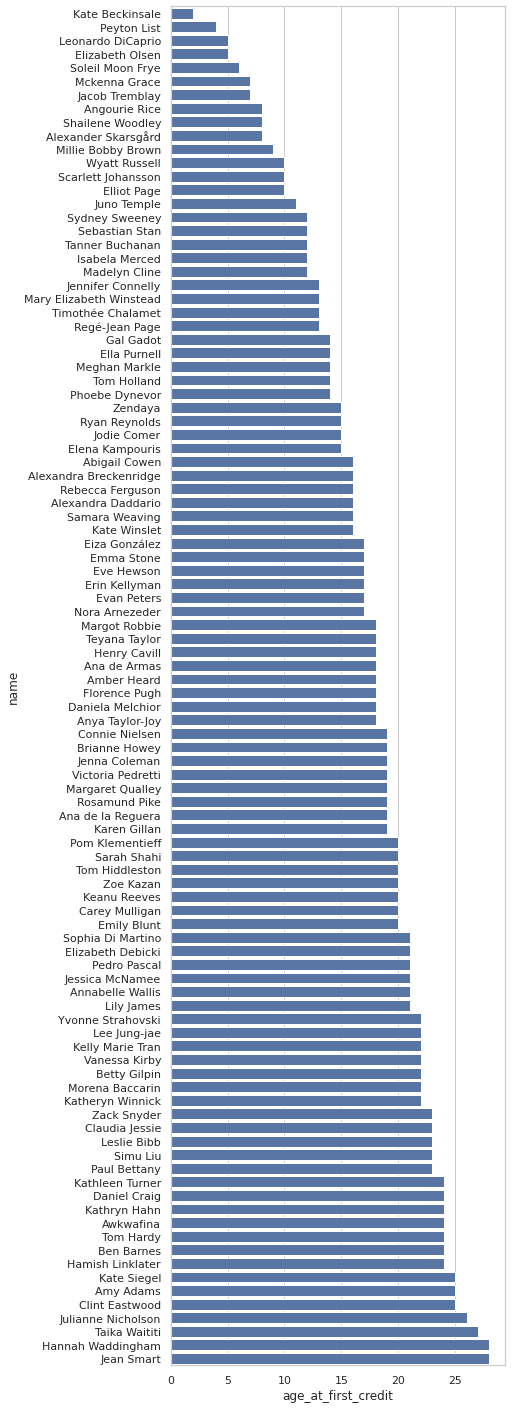

In [39]:
# BEGIN SOLUTION NO PROMPT
frame['age_at_first_credit'] = frame.year_first_credit-frame.year_born

# Plot was not necessary for students
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(6, 25))
frame_to_plot = frame.sort_values(by=['age_at_first_credit'], ascending=True)
sns.barplot(x='age_at_first_credit', y='name', data=frame_to_plot, label='Age At First Credit', color='b');
# END SOLUTION

In [40]:
# You should visually inspect some of your results
frame.head()

,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
0,Elizabeth Olsen,actress,woman,1989,How the West Was Fun,1994,26,5
1,Regé-Jean Page,actor,man,1988,Gimme 6,2001,20,13
2,Florence Pugh,actress,woman,1996,The Falling,2014,28,18
3,Ana de Armas,actress,woman,1988,Una rosa de Francia,2006,32,18
4,Yvonne Strahovski,actress,woman,1982,Double the Fist,2004,39,22


In [ ]:
grader.check("q6")

<div class='exercise'><b>Q7 - Subsetting and Sorting</b></div>

In this section you'll subset and sort the DataFrame to answer a pair of questions:

<div class='exercise'><b>Q7.1 - Child Stars</b></div>

Which stars received their first credit **before the age of 11?**

Store the resulting dataframe as `child_stars`sorted by `age_at_first_credit` in **ascending** order.\
Store the number of such "child stars" in `num_child_stars`.

_Points:_ 2.5

In [43]:
child_stars = frame[frame['age_at_first_credit'] < 11].sort_values('age_at_first_credit') # SOLUTION
num_child_stars = child_stars.shape[0] # SOLUTION

print ("{} stars received their first credit before the age of 11.".format(num_child_stars))
display(child_stars)

14 stars received their first credit before the age of 11.


,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
33,Kate Beckinsale,actress,woman,1973,Couples,1975,54,2
86,Peyton List,actress,woman,1998,As the World Turns,2002,62,4
0,Elizabeth Olsen,actress,woman,1989,How the West Was Fun,1994,26,5
75,Leonardo DiCaprio,actor,woman,1974,Romper Room,1979,46,5
95,Soleil Moon Frye,actress,woman,1976,Missing Children: A Mother's Story,1982,60,6
31,Mckenna Grace,actress,woman,2006,The Goodwin Games,2013,69,7
80,Jacob Tremblay,actor,man,2006,Motive,2013,40,7
17,Alexander Skarsgård,actor,man,1976,Ake and His World,1984,70,8
40,Angourie Rice,actress,woman,2001,Hidden Clouds,2009,26,8
50,Shailene Woodley,actress,woman,1991,Replacing Dad,1999,41,8


In [ ]:
grader.check("q7.1")

<div class='exercise'><b>Q7.2 - Late Bloomers</b></div>

Which stars received their first credit at **26-years-old or older?**

Store the resulting dataframe as `late_bloomers`sorted by `age_at_first_credit` in **descending** order.\
Store the number of such "late bloomers" in `num_late_bloomers`.

_Points:_ 2.5

In [45]:
late_bloomers = frame[frame['age_at_first_credit'] > 25].sort_values('age_at_first_credit', ascending=False) # SOLUTION
num_late_bloomers = late_bloomers.shape[0] # SOLUTION

print ("{} stars received their first credit at 26 or older.".format(num_late_bloomers))
display(late_bloomers)

4 stars received their first credit at 26 or older.


,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
22,Hannah Waddingham,actress,woman,1974,Coupling,2002,37,28
89,Jean Smart,actress,woman,1951,Before and After,1979,124,28
96,Taika Waititi,writer,man,1975,John & Pogo,2002,28,27
83,Julianne Nicholson,actress,woman,1971,Nothing Sacred,1997,64,26


In [ ]:
grader.check("q7.2")

<div class='exercise'><b>Q8 - Visualization  </b></div>

In this section you'll use your Python visualization skills to further explore the data:

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q8.1  - Exploring Trends</b></div>

Create 2 [scatter plots](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html?highlight=scatter#matplotlib.axes.Axes.scatter): one showing the relationship between **age at first movie** and number of credits, the other between **year born** and number of credits.

What can you say about these relationships? Are there any apparent outliers? Please limit your written responses to 4 sentences or fewer.

_Points:_ 5

_Type your answer here, replacing this text._

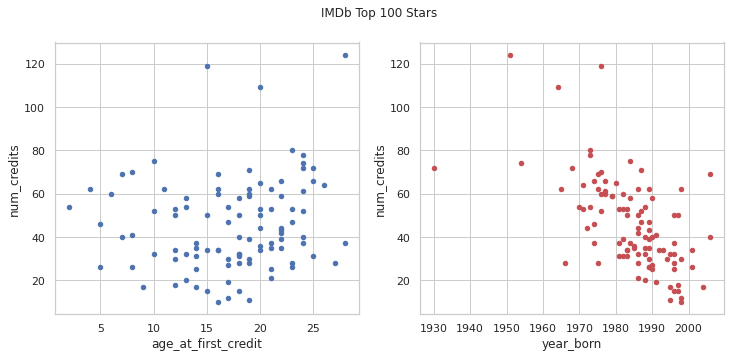

In [47]:
# your code here

# BEGIN SOLUTION NO PROMPT
fig, axes = plt.subplots(1,2, figsize=(12,5))
frame.plot(x='age_at_first_credit', y='num_credits', kind='scatter', c='b', ax=axes[0]);
frame.plot(x='year_born', y='num_credits', kind='scatter', c='r', ax=axes[1]);
plt.suptitle("IMDb Top 100 Stars");
# END SOLUTION

*your answer here*

<div style='color:blue'>
There is no obvious relationship between `age_at_first_credit` and `num_credits`, but there is a negative relationship between `year_born` and `num_credits`. This is not surprising as younger stars have had fewer years to accumulate credits! While there are no extreme outliers there is one point that does stand out a bit: Clint Eastwood born in 1930. He has fewer credits than you might expect for someone his age given the trend, but it is likely that, in a stars later years, they are not working quite as much so the later years produce fewer credits than the early years.
</div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q8.2 - Age Distributions</b></div>

Let's look at the distribution of movie and TV performers' ages by gender.

Create two plots, each plot consisting of **two overlayed [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html?highlight=hist#matplotlib.pyplot.hist)** comparing the distribution of men's current ages to women's current ages.

In the first plot, the distributions should be normalized to show the *proportion* of each gender at each age.

The second plot should show the *counts* of each gender at each age. 

Interpret the resulting plots. (4 sentences or fewer)

>**NOTE 1:** Again, we are dealing with *approximate* ages as defined above.

>**NOTE 2:** You should exclude those whose `role` is not 'actor' or 'actress' from your analysis

_Points:_ 10

_Type your answer here, replacing this text._

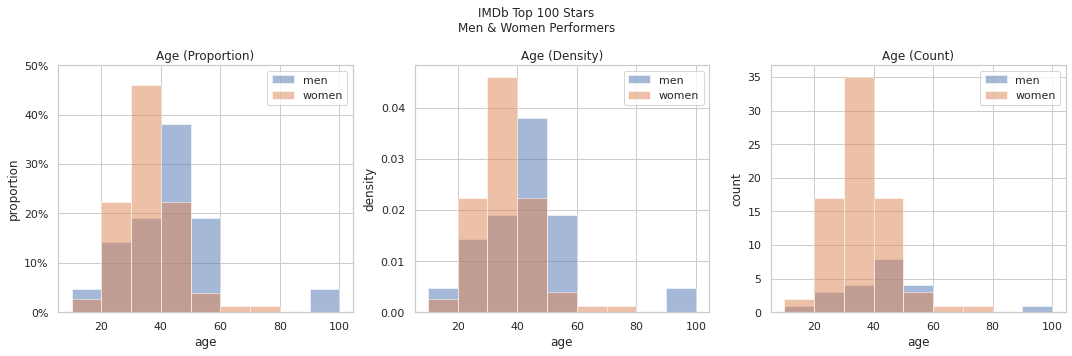

In [48]:
# your code here

# BEGIN SOLUTION NO PROMPT
performers = frame[frame.role.isin(['actor', 'actress'])]
women_ages = 2022 - performers[performers.gender == 'woman'].year_born
men_ages = 2022 - performers[performers.gender == 'man'].year_born

fig, axes = plt.subplots(1,3, figsize=(15,5))

for ylabel, ax in zip(['proportion', 'density', 'count'], axes):
    for group, data in {'men': men_ages, 'women': women_ages}.items():
        _, _, patches = ax.hist(data, alpha=0.5, bins=range(10,101,10), label=group, density=(ylabel == 'density'));
        # if proportion, rescale heights and adjust y-axis
        # This method will work regardless of the number/location of bins used
        if ylabel == 'proportion':
            [c.set_height(c.get_height()/len(data)) for c in patches.get_children()]
            ax.yaxis.set_major_formatter('{x:.0%}')
            ax.set_ylim(0,0.5)
        ax.set(ylabel=ylabel, xlabel='age', title=f'Age ({ylabel.capitalize()})');
        ax.legend()
plt.suptitle("IMDb Top 100 Stars\nMen & Women Performers");
plt.tight_layout()
# END SOLUTION

*your answer here*

**Note:** For the 1st histogram eith proportion or density would have been acceptable.

<div style='color:blue'>
If we 'bin' ages by decade we can see that most of the women are in their thirties while most of the men are in their forties. In general, the ages distribution for men compared to women is shifted to the right (i.e., older). We can also see by comparing the proportion and density plots to the count plot that their are far more women in the IMDb Top 100 Stars list than men.
</div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q8.3 - Credits Per Year</b></div>

Create a [box plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot) or [violin plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.violin.html?highlight=violin#matplotlib.axes.Axes.violin) comparing the **credits-per-year-active** for men and women performers.

Here we assume all stars in the list are still active. 

Do these distributions look the same across genders? Can you identify the stars corresponding to any outliers? Comment on these points and anything else of interest gleaned from your plot. (6 sentences or fewer)

>**NOTE:** Again, you should exclude those whose `role` is not 'actor' or 'actress' from your analysis.

_Points:_ 10

_Type your answer here, replacing this text._

Outliers


,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit,years_active,cpya
78,Simu Liu,actor,man,1989,Nikita,2012,47,23,10,4.700000
80,Jacob Tremblay,actor,man,2006,Motive,2013,40,7,9,4.444444


,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit,years_active,cpya
31,Mckenna Grace,actress,woman,2006,The Goodwin Games,2013,69,7,9,7.666667


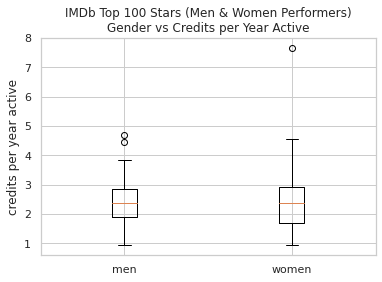

In [49]:
# your code here
# BEGIN SOLUTION NO PROMPT
performers = performers.assign(years_active=lambda x: 2022 - x.year_first_credit,
                  cpya=lambda x: x.num_credits / x.years_active)

boxplot = plt.boxplot([performers[performers.gender =='man'].cpya,
                       performers[performers.gender == 'woman'].cpya])
plt.title('IMDb Top 100 Stars (Men & Women Performers)\nGender vs Credits per Year Active')
plt.xticks(ticks=[1,2], labels=['men', 'women'])
plt.ylabel('credits per year active');


def get_outliers(df, col):
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)
    IQR = Q3 - Q1
    return df[(df[col] < Q1-1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]

print("Outliers")
display(get_outliers(performers[performers.gender == 'man'], 'cpya'))
display(get_outliers(performers[performers.gender == 'woman'], 'cpya'))
# END SOLUTION

*your answer here*

<div style='color:blue'>
    There is not a significant difference in the median credits-per-year-active (CBYA) between men and women which is roughly 2.4 for both groups. However, the distribution for men has less spread and is more symmetrical while the distribution for women is more right skewed with some women in the 4th quartile having made an additional movie per year active than men in the 4th quartile. The outlier among the women is also more extreme with Simu Liu and Jacob Tremblay each have about 4.5 CPYA while Mckenna Grace, the outlier among the women, has more than 7.5 CPYA! This high number seems to be a result of Mckenna Grace doing primarily TV work: mini series, TV movies, voice acting for animated shows, etc. The production time on these projects is likely much shorter than a 'feature fim' so more of them can fit into a year's work. She also appears to have several actress credits for music videos for which the production times are also very short compared to movies.
</div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q9 - Most Prolific Stars</b></div>

Make a plot visualizing the number of credits received by each star. Who is the most prolific person in IMDb's list of the Top 100 Stars for 2021? Define **most prolific** as the person with the most credits.

>**Note 1:** Your analysis should include all 100 stars

>**Note 2:** The stars in the plots should be sorted based on number of credits to make the plot easier to read.

_Points:_ 10

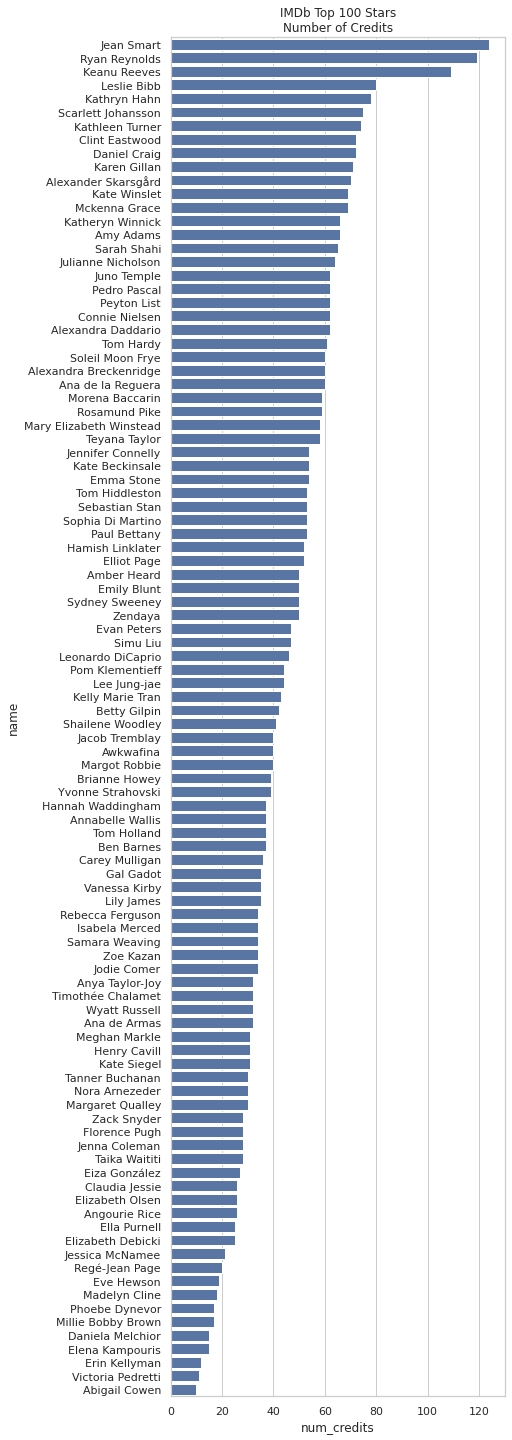

In [50]:
# your code here

# BEGIN SOLUTION NO PROMPT
sns.set(style='whitegrid')

# initialize the figure
fig, ax = plt.subplots(figsize=(6, 25))

# prepare the dataframe
frame_to_plot = frame.sort_values(by=['num_credits'], ascending=False)

sns.barplot(x='num_credits', y='name', data=frame_to_plot, label='Credits', color='b', ax=ax);
ax.set_title("IMDb Top 100 Stars\nNumber of Credits");
# END SOLUTION

In [51]:
highest_performer_name = frame.name[frame.num_credits.idxmax()] # SOLUTION
highest_performer_credits = frame.num_credits[frame.num_credits.idxmax()] # SOLUTION
print ("{} had the most credits with {}".format(highest_performer_name, highest_performer_credits))

Jean Smart had the most credits with 124


<!-- END QUESTION -->

**This concludes HW1. Thank you!**